# Feature Analysis

In [1]:
import pandas as pd
import math

In [2]:
filenames1 = ['pionminus','pionminus1','pionminus2','pionminus3','pionminus4','pionminus5']
filename2 = 'TreenewDB'#'electron1'
filepath = "/home/yoren/bnl/PHENIX/ee/ML/"

hadron_weight = 25000*50/500

In [3]:
if False:
    data1 = pd.read_csv(filepath+f'{filenames1[0]}.csv')
    data1.loc[data1['phi0'] > -99, 'phi0'] = 0
    for ifile in range(1,len(filenames1)):
        idata = pd.read_csv(filepath+f'{filenames1[ifile]}.csv')
        idata.loc[idata['phi0'] > -99, 'phi0'] = 0
        data1 = pd.concat([data1,idata], sort=False)
    data1 = pd.concat([data1,data1], sort=False)
    data1 = pd.concat([data1,data1], sort=False)
    data1 = pd.concat([data1,data1], sort=False)
    data1 = pd.concat([data1,data1], sort=False)

    data = pd.concat([data1,data2], sort=False)
    data = data.sample(frac = 1)
    data['phi0'] = data['phi0'].astype('int32')
    data['centrality'] = data['centrality'].astype('int32')
    data['zvertex'] = data['zvertex'].astype('float16')
    data['pt'] = data['pt'].astype('float16')
    data['e/p'] = data['e/p'].astype('float16')
    data['n0'] = data['n0'].astype('int32')
    data['disp'] = data['disp'].astype('float16')
    data['chi2'] = data['chi2'].astype('float16')
    data['npe0'] = data['npe0'].astype('int32')
    data['prob'] = data['prob'].astype('float16')
    data.head()
    
    data['disp2'] = data.apply(lambda row: row['disp']**2, axis=1)
    data['n0*disp'] = data.apply(lambda row: (row['n0']-2)/(1+row['disp']), axis=1)
    data['n0*disp2'] = data.apply(lambda row: (row['n0']-2)/(1+row['disp'])**0.5, axis=1)
    data['chi2/npe0'] = data.apply(lambda row: row['chi2']/(row['npe0']+0.001), axis=1)
    data['e/p*prob'] = data.apply(lambda row:  math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2*(row['prob']), axis=1)
    data['n0*prob'] = data.apply(lambda row: (row['n0']-2)*(row['prob']+0.001), axis=1)
    data['prob-1'] = data.apply(lambda row: 1./(1.00001-row['prob'])**0.5, axis=1)
    data['e/p*pt'] = data.apply(lambda row: ((row['pt'])**0.5)*math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2, axis=1)
    data['n0*pt'] = data.apply(lambda row: (row['n0']-2)*(row['pt']+0.001)**0.5, axis=1)
    #data['e/p*centrality'] = data.apply(lambda row: row['e/p']*(row['centrality']+0.001)**0.5, axis=1)
    #data['n0*centrality'] = data.apply(lambda row: row['n0']*(row['centrality']+0.001)**0.5, axis=1)
    data['n0-2'] = data.apply(lambda row: (row['n0']-2)*(row['n0']), axis=1)
    data['e/p-0.8'] = data.apply(lambda row: math.copysign(1,row['e/p']-0.8)*(row['e/p']-0.8)**2, axis=1)
    data['pt-1'] = data.apply(lambda row: row['pt']**-1, axis=1)
    data['pt2'] = data.apply(lambda row: row['pt']**2, axis=1)
    data['centrality-2'] = data.apply(lambda row: row['centrality']**-2, axis=1)
    data.head()

In [4]:
data = pd.read_csv(filepath+f'{filename2}.csv')
#data2.loc[data2['phi0'] > -99, 'phi0'] = 1
#data2 = data2[:100000]

In [5]:
print(data.size, data.shape)

163286805 (10885787, 15)


In [6]:
# удалим лишние колонки
data = data.drop(columns = ['zvertex'])

In [7]:
import matplotlib.pyplot as plt

def analysis(data: pd.DataFrame):
    fig, ax = plt.subplots(3, 3, figsize=(15, 6))
    for i, feature in enumerate(['centrality', 'pt', 'e/p', 'n0', 'disp', 'chi2', 'npe0', 'prob', 'phi0']):
        x, y = divmod(i, 3)
        data[feature].plot.hist(ax=ax[x][y], ylabel='', title=feature, color='skyblue', logy=True)


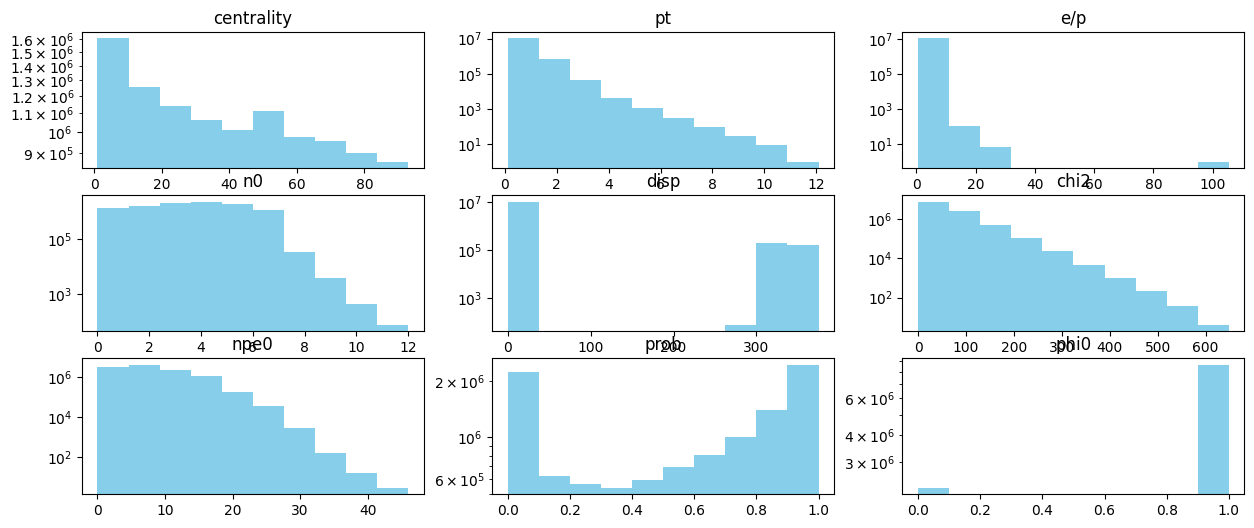

In [8]:
analysis(data)

+ Видим, что impressions имеют только одно значение, поэтому их можно удалить.
+ Таргет-переменная clicks сильно несбалансирована. Возможно, стоит использовать балансировку весов, а также в качестве оценки моделей использовать f1 и ROC AUC.
+ У campaign_clicks нулевых значений сильно больше, чем ненулевых, следовательно, можно трансформировать в бинарную фичу
+ os_id со значениями больше 6 встречается редко, можно объединить в одну категорию
+ Аналогично с редкими значениями zone_id

# Feature Engineering

In [9]:
def feature_engineering(data: pd.DataFrame) -> pd.DataFrame:
    # делим выборку на train и test
    #data = data.sort_values(by='date_time', ignore_index=True)
    #cut_off_val = data[data['date_time'] < pd.to_datetime('2021-10-01')].index[-1]
    #cut_off_test = data[data['date_time'] < pd.to_datetime('2021-10-02')].index[-1]

    cut_off_val =  int (data.shape[0]/3)
    cut_off_test = int (data.shape[0]/3*2 + 1)

    print(cut_off_val,cut_off_test)

    y = data['phi0']
    data = data.drop(columns = ['phi0'])
    data_train, data_test = data[:cut_off_test], data[cut_off_test:]
    y_train, y_test = y.iloc[:cut_off_test], y.iloc[cut_off_test:]
    
    # делаем one hot encodings
    #enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    #enc.fit(data_train)
    #transformed_train = enc.transform(data_train)
    #transformed_test = enc.transform(data_test)
    
    return data_train, data_test, y_train, y_test,cut_off_val

In [10]:
X_train_all, X_test, y_train_all, y_test, cut_off_val = feature_engineering(data)

3628595 7257192


In [11]:
X_test

centrality      pt     e/p  n0     disp     chi2  npe0     prob  \
7257192           78  0.8276  0.9220   3    2.543   57.200     5  0.42400   
7257193           36  0.7120  1.1270   7    1.883    5.140    10  0.85550   
7257194           35  1.1740  0.8210   0  326.500  111.700     0  0.02460   
7257195           58  0.7554  0.9170   5    0.916   57.530     8  0.51200   
7257196           71  0.5537  0.8460   3    3.816   29.080     8  0.76460   
...              ...     ...     ...  ..      ...      ...   ...      ...   
10885782           5  0.3728  0.8560   5    1.526   19.450    11  0.01634   
10885783          79  0.9110  1.3955   6    1.762  125.750    13  0.72950   
10885784           3  0.7144  0.8050   5    2.248    1.871     8  0.78100   
10885785          42  0.4053  1.0460   5    2.123   39.340    13  0.76300   
10885786          87  0.6265  0.9556   4    2.560  113.200    10  0.41970   

                  disp2      chi2/npe0  centr+pt    e/p*pt     n0*pt  
7257192       -3.466690      11.435213  5.555273  6.310547  7.763916  
7257193        3.455017       0.514011  3.223828  9.847656  8.161917  
7257194  -106602.250000  111687.500000  4.097656  4.695312  7.174231  
7257195        4.160915       7.190507  4.410742  8.021484  8.098014  
7257196      -11.564957       3.634311  4.657422  5.214844  8.996621  
...                 ...            ...       ...       ...       ...  
10885782       2.670203       1.768305  0.995605  6.491211  4.247943  
10885783       2.896347       9.672333  5.772266  9.644531  6.221568  
10885784      -0.053715       0.233857  1.578711  7.857422  9.037711  
10885785       0.492672       3.026210  2.910547  6.621094  6.809703  
10885786      -2.556400      11.317618  5.602930  6.505859  6.447234  

[3628595 rows x 13 columns]

In [12]:
X_train, X_val = X_train_all[:cut_off_val], X_train_all[cut_off_val:]
y_train, y_val = y_train_all[:cut_off_val], y_train_all[cut_off_val:]
w_train, w_val = y_train-1, y_val-1
w_test = y_test-1
w_train_all = y_train_all - 1
w_train = w_train*(-hadron_weight)+1
w_val = w_val*(-hadron_weight)+1
w_test = w_test*(-hadron_weight)+1
w_train_all = w_train_all*(-hadron_weight)+1

+ Увидели, что количество кликов меняется в зависимости от дня недели и часа, добавим в качестве фичей
+ Также, добавим интеракции между этими двумя переменными, так как в разные дни недели разные часы могут по-разному влиять на колличество кликов
+ banner_id удалила, так как предполагаю, что модель должна уметь предсказывать клики для новых баннеров тоже.
+ Так как все оставшиеся фичи являются категориальными, сделали one-hot-encoding


+ В качестве теста берем последний день датасета, в качестве валидации -- предпоследний

# Create Model

In [13]:
from sklearn import metrics
from sklearn.ensemble import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate= 0.1, max_features=2, max_depth=2, random_state=0)
gb_clf.fit(X_train, y_train, w_train)

predicted = gb_clf.predict(X_test)

# calculating the main quality metrics
print(metrics.classification_report(y_test, predicted))

print('confusion matrix')
print(metrics.confusion_matrix(y_test, predicted))

/home/yoren/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/yoren/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/yoren/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.21      1.00      0.34    753068
           1       0.00      0.00      0.00   2875527

    accuracy                           0.21   3628595
   macro avg       0.10      0.50      0.17   3628595
weighted avg       0.04      0.21      0.07   3628595

confusion matrix
[[ 753068       0]
 [2875527       0]]


In [ ]:
# search for parameters
# https://www.kaggle.com/hatone/gradientboostingclassifier-with-gridsearchcv
import time
from sklearn.model_selection import GridSearchCV

start = time.time() 

parameters = {
    "loss":["log_loss"],
    "learning_rate": [0.01, 0.2],
    "min_samples_split": [0.01, 0.2],
    "max_depth":[8,12],
    "max_features":["log2","sqrt"],
    "criterion": ['squared_error'],
    "n_estimators":[10,20]
    }

classif = GradientBoostingClassifier()
classif.set_params(init='zero')

clf = GridSearchCV(classif, parameters, cv=3, n_jobs=8)

clf.fit(X_train, y_train, sample_weight=w_train)
print('точность: ', clf.score(X_test, y_test))

# getting the best parameters ans score
print(clf.best_params_)
print(clf.best_score_)

stop = time.time()    
print('time of execution (sec)', stop - start)

точность:  0.3116553376720191
{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 12, 'max_features': 'log2', 'min_samples_split': 0.01, 'n_estimators': 20}
0.32910424082943596
time of execution (sec) 350.5936508178711


# Cross Validation

In [15]:
predicted = clf.predict(X_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.23      1.00      0.38    753068
           1       1.00      0.13      0.23   2875527

    accuracy                           0.31   3628595
   macro avg       0.62      0.57      0.30   3628595
weighted avg       0.84      0.31      0.26   3628595



In [16]:
y_pred_probs = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

# Model Evaluation

log loss: 0.015597342620711045
roc auc: 0.9588985760782696
f1 score: 0.9237531548896609


Text(0.5, 1.0, 'ROC AUC Curve')

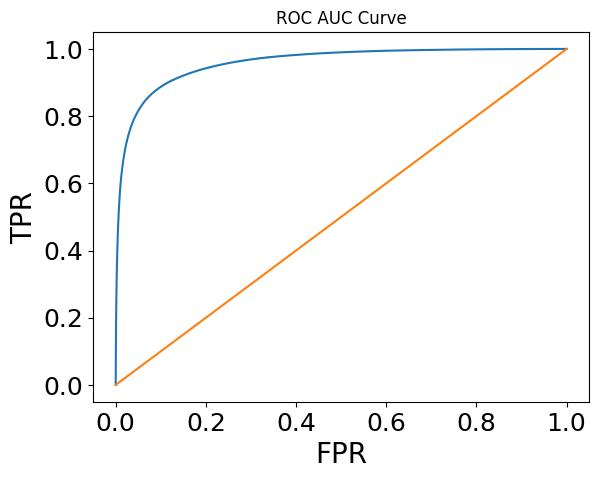

In [17]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import roc_auc_score, log_loss, f1_score

print('log loss:', log_loss(y_test, y_pred_probs, sample_weight=w_test))

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_probs[:, 1], pos_label=1, sample_weight=w_test)
metrics.auc(fpr, tpr)
print('roc auc:', metrics.auc(fpr, tpr))

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
y_pred_opt = y_pred_probs[:, 1] > optimal_threshold
print('f1 score:', f1_score(y_test, y_pred_opt))
plt.plot(fpr, tpr)
plt.plot(fpr, fpr)
plt.xlabel("FPR", fontsize=20)
plt.ylabel("TPR", fontsize=20)
plt.xticks(fontsize = 18) 
plt.yticks(fontsize = 18) 
plt.title('ROC AUC Curve')

In [18]:
pred_baseline = np.ones_like(y_test) * y_test.mean()
print("baseline auc:", roc_auc_score(y_test, pred_baseline))
print("baseline log_loss:", log_loss(y_test, pred_baseline))

baseline auc: 0.5
baseline log_loss: 0.5106751464913369


In [138]:
i = 70000
print(round(tpr[i],3),round(fpr[i]/tpr[i],4))
print(thresholds[i],fpr[i],tpr[i])
#print((fpr[i]/tpr[i]*data1.shape[0]/data2.shape[0]/10)**-1,(fpr[i]/1.*data1.shape[0]/data2.shape[0]/10)**-1)

0.508 0.0128
0.040137850208796184 0.006516011834256668 0.5082070173571662


In [139]:
print(sum(predicted),len(predicted))

378573 3628595


In [140]:
kek_data = data
kek_data = kek_data.drop(columns = ['phi0'])
proba_loc = clf.predict_proba(kek_data)
print(proba_loc[0][1])

0.009620970676902575


In [141]:
import ROOT as root
outfile = root.TFile.Open("output/BDT_test1.root", "recreate")
e_pt_hist_AI = root.TH2D("e_pt_hist_AI", "e_pt_hist_AI", 20, 0, 5, 10, 0, 100)
h_pt_hist_AI = root.TH2D("h_pt_hist_AI", "h_pt_hist_AI", 20, 0, 5, 10, 0, 100)
e_pt_hist_SC = root.TH2D("e_pt_hist_SC", "e_pt_hist_SC", 20, 0, 5, 10, 0, 100)
h_pt_hist_SC = root.TH2D("h_pt_hist_SC", "h_pt_hist_SC", 20, 0, 5, 10, 0, 100)
e_pt_hist_NC = root.TH2D("e_pt_hist_NC", "e_pt_hist_NC", 20, 0, 5, 10, 0, 100)
h_pt_hist_NC = root.TH2D("h_pt_hist_NC", "h_pt_hist_NC", 20, 0, 5, 10, 0, 100)

In [142]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = data.reset_index()  # make sure indexes pair with number of rows

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>100000000: break
    centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 = row['centrality'], row['pt'], row['e/p'], row['n0'], row['disp'], row['chi2'], row['npe0'], row['prob'], row['phi0']
    if pt<0.4 or centrality<0: continue
    if phi0: e_pt_hist_NC.Fill(pt,centrality)
    else:    h_pt_hist_NC.Fill(pt,centrality)
    if ep>0.8 and n0>=2 and disp <5 and prob>0.01 and chi2/(npe0+1e-4)<10: 
        if phi0: 
            mycute+=1
            e_pt_hist_SC.Fill(pt,centrality)
        else: 
            mycuth+=1+hadron_weight
            h_pt_hist_SC.Fill(pt,centrality)
    if proba_loc[counter][1]>thresholds[i]: 
        if phi0: 
            AIcute+=1
            e_pt_hist_AI.Fill(pt,centrality)
        else: 
            AIcuth+=1+hadron_weight
            h_pt_hist_AI.Fill(pt,centrality)
    if phi0: norm_e+=1
    else: norm_h+=1+hadron_weight
    #if counter<10: 
    #    print(proba_loc[counter],answer(centrality,pt,ep,n0,disp,chi2,npe0,prob))
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )

In [143]:
print(norm_e, norm_h,round(mycute/norm_e,3),round(mycuth/norm_h,3), round(AIcute/norm_e,3), round(AIcuth/norm_h,3), round(AIcuth/AIcute/norm_h*norm_e,3),round(fpr[i]/tpr[i],3))

7703176 5373758644.0 0.62 0.034 0.519 0.005 0.01 0.013


In [144]:
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h))

5.215 0.836 0.16 2889


In [145]:
%run input/Format.ipynb
%jsroot on

/home/yoren/.local/lib/python3.10/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


In [146]:
c1 = root.TCanvas("c1","c1",1400,2500)
c1.Divide(2,5)
part_names_legend= [ "e^{-} " , "#pi^{-} "]
centralities_legend = ["0-20%","20-40%","40-60%","60-80%","80-93%"]
legends = []
for icentr in range(5):

    c1.cd(1+2*icentr)
    root.gPad.SetLogy()
    e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}").SetLineWidth(3)
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}").SetLineWidth(3)
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}").SetLineWidth(3)
    e_pt_hist_NC.SetLineColor(4)
    e_pt_hist_SC.SetLineColor(2)
    e_pt_hist_AI.SetLineColor(1)
    proj = e_pt_hist_NC.ProjectionX(f"e_pt_hist_NC_{icentr}",icentr+1,icentr+1)
    proj.SetMinimum(100)
    Format_Hist_total(proj, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    proj.Draw()
    e_pt_hist_SC.ProjectionX(f"e_pt_hist_SC_{icentr}",icentr+1,icentr+1).Draw("same")
    e_pt_hist_AI.ProjectionX(f"e_pt_hist_AI_{icentr}",icentr+1,icentr+1).Draw("same")

    legends.append(Draw_Legend_Title(0.6,0.6,0.9,0.9,part_names_legend[0]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].Draw()

    c1.cd(2+2*icentr)
    root.gPad.SetLogy()
    h_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}").SetLineWidth(3)
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}").SetLineWidth(3)
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}").SetLineWidth(3)
    h_pt_hist_NC.SetLineColor(4)
    h_pt_hist_SC.SetLineColor(2)
    h_pt_hist_AI.SetLineColor(1)
    projh = e_pt_hist_NC.ProjectionX(f"h_pt_hist_NC_{icentr}",icentr+1,icentr+1)
    projh.SetMinimum(100)
    Format_Hist_total(projh, title_x="p_{T} [GeV]",  title_y="dN/dp_{T}", left=0.15, bottom=0.15, right=0.01, top=0.01,  Tsize=0.07,  Lsize=0.06,\
                      Mstyle=21,  Msize=2, Mcolor=4,  Lwidth=3,  Lcolor=4,  offset_x=1, offset_y=1, title="",  Malpha=1,  Lalpha=1)
    projh.SetMinimum(2)
    projh.Draw()
    h_pt_hist_SC.ProjectionX(f"h_pt_hist_SC_{icentr}",icentr+1,icentr+1).Draw("same")
    h_pt_hist_AI.ProjectionX(f"h_pt_hist_AI_{icentr}",icentr+1,icentr+1).Draw("same")

    legends.append(Draw_Legend_Title(0.6,0.6,0.9,0.9,part_names_legend[1]+centralities_legend[icentr],TextSize=0.08, align =22, LineWidth=0, Color=1,  alpha=0))
    legends[-1].Draw()
c1.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


In [147]:
if False:
    e_pt_hist_AI.Write()
    h_pt_hist_AI.Write()
    e_pt_hist_SC.Write()
    h_pt_hist_SC.Write()
    e_pt_hist_NC.Write()
    h_pt_hist_NC.Write()
    outfile.Close()

In [148]:
import pickle
with open('output/bdt.pkl','wb') as f:
    pickle.dump(clf,f)

print(clf.predict(kek_data[0:10]))

[0 0 0 0 0 0 0 0 0 0]


In [149]:
import pickle
# load
with open('output/bdt.pkl', 'rb') as f:
    clf2 = pickle.load(f)
print(clf2.predict(kek_data[0:10]))

[0 0 0 0 0 0 0 0 0 0]


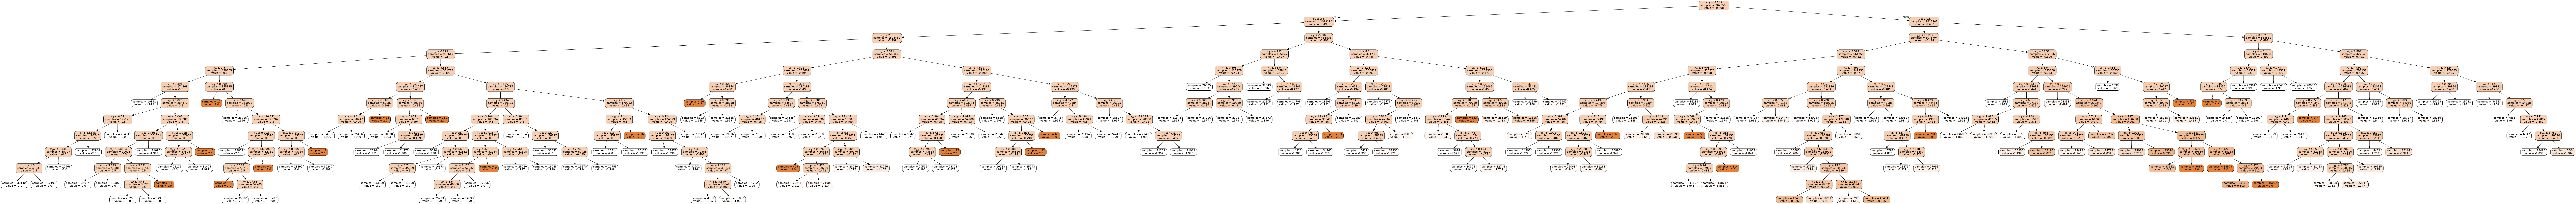

In [150]:
sub_tree_42 = clf2.best_estimator_[0, 0]
from sklearn.tree import export_graphviz, export_text
from sklearn.tree import _tree
# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)

graph = graph_from_dot_data(dot_data)
png = graph.create_png()
# Save (optional)
from pathlib import Path
Path('output/out.png').write_bytes(png)
# Display
Image(png)

In [151]:
clf2.predict(kek_data[0:100])

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [152]:
clf2.predict_proba(kek_data[0:100])

array([[0.99037903, 0.00962097],
       [0.63260083, 0.36739917],
       [0.87511069, 0.12488931],
       [0.99131306, 0.00868694],
       [0.90681952, 0.09318048],
       [0.99047049, 0.00952951],
       [0.84659719, 0.15340281],
       [0.98761524, 0.01238476],
       [0.99145058, 0.00854942],
       [0.98323808, 0.01676192],
       [0.99079211, 0.00920789],
       [0.9730594 , 0.0269406 ],
       [0.97579003, 0.02420997],
       [0.48281083, 0.51718917],
       [0.99121431, 0.00878569],
       [0.24278486, 0.75721514],
       [0.97382286, 0.02617714],
       [0.98357012, 0.01642988],
       [0.98795121, 0.01204879],
       [0.98723066, 0.01276934],
       [0.90937729, 0.09062271],
       [0.92130676, 0.07869324],
       [0.99088864, 0.00911136],
       [0.99123434, 0.00876566],
       [0.97430185, 0.02569815],
       [0.77254112, 0.22745888],
       [0.97953536, 0.02046464],
       [0.56281097, 0.43718903],
       [0.98455038, 0.01544962],
       [0.70116839, 0.29883161],
       [0.

In [153]:
print( clf2.best_params_)

{'criterion': 'squared_error', 'learning_rate': 0.2, 'loss': 'log_loss', 'max_depth': 12, 'max_features': 'log2', 'min_samples_split': 0.01, 'n_estimators': 20}


In [154]:
clf2.best_estimator_.predict_proba(kek_data[9:20])

array([[0.98323808, 0.01676192],
       [0.99079211, 0.00920789],
       [0.9730594 , 0.0269406 ],
       [0.97579003, 0.02420997],
       [0.48281083, 0.51718917],
       [0.99121431, 0.00878569],
       [0.24278486, 0.75721514],
       [0.97382286, 0.02617714],
       [0.98357012, 0.01642988],
       [0.98795121, 0.01204879],
       [0.98723066, 0.01276934]])

In [155]:
y = clf2.best_estimator_[0, 0].predict(kek_data[9:19].values.tolist())*0
#y = gb_clf.decision_function(kek_data[9:20])

rate = clf2.best_params_['learning_rate']
print(rate)
for i in range(0,10):
    sub_tree = clf2.best_estimator_[i, 0]
    y += rate*sub_tree.predict(kek_data[9:19].values.tolist())
print(y)
print(gb_clf.decision_function(kek_data[9:20]))
z=y
for i in range(len(z)): 
    z[i] = 1./(1+np.exp(-z[i]))
print(z)

0.2
[-2.52933779 -2.67864395 -2.38367745 -2.52066028 -0.46671842 -2.69253457
  0.2730121  -2.46323594 -2.52068852 -2.64435776]
[-2.81493599 -6.98303769 -3.98255596 -5.7659225  -3.39489741 -7.31535441
 -0.41201235 -4.48590945 -4.24497028 -6.1695611  -6.21140899]
[0.07382691 0.06424535 0.08442587 0.07442245 0.38539324 0.06341531
 0.56783222 0.078476   0.0744205  0.06633762]


In [156]:
best_gbc = clf2.best_estimator_

In [157]:
n_estim = best_gbc.n_estimators

In [158]:
learning_rate = best_gbc.learning_rate
print(clf2.decision_function(kek_data[9:19]))
arr = clf2.decision_function(kek_data[9:19])
print(1./(1.+np.exp(-arr)))
#tree_scores = [best_gbc.estimators_[i, 0].decision_function(kek_data[9:19].values.tolist()) for i in range(10)]
print(learning_rate)

[-4.07174188 -4.67844443 -3.58681057 -3.69648299  0.06878377 -4.72580616
  1.13747171 -3.61634295 -4.09208732 -4.40666927]
[0.01676192 0.00920789 0.0269406  0.02420997 0.51718917 0.00878569
 0.75721514 0.02617714 0.01642988 0.01204879]
0.2


In [159]:
log_odds_predictions = []
for tree in clf2.best_estimator_:
    # For each tree, get the predicted values for each sample
    leaf_indices = tree[0].apply(kek_data[9:19].values.tolist())  # Get the leaf indices for the training data
    leaf_values = tree[0].tree_.value  # Get the values at each leaf

    # Average the values for each leaf to interpret them as log odds
    predicted_log_odds = [leaf_values[leaf_indices[i]].mean() for i in range(len(kek_data[9:19]))]
    log_odds_predictions.append(predicted_log_odds)

In [160]:
print(log_odds_predictions)

[[-1.9894329012728185, -1.993206405905068, -1.9781422124062462, -1.9329671359984482, -1.7055003306179675, -1.9970304146515456, 0.042918196593029555, -1.9781422124062462, -1.9767495145861191, -1.9971898246576827], [-1.5529513572321754, -1.6698677318896868, -1.6577091503085386, -1.6652386999002926, -1.0523925820875073, -1.670064869157843, 0.31846390988318457, -1.6577091503085386, -1.6008761340602635, -1.6627343361393527], [-1.453269189998311, -1.4791398057210643, -1.450673564947761, -1.4245175294266248, -1.1380006175127948, -1.4794701435381887, -0.35133443749524357, -1.4623507019979969, -1.4612499909107333, -1.4661373788700975], [-1.2892182760054889, -1.3521954315475386, -1.2271656004149727, -1.3520625028841313, 2.6477327696443287, -1.356193117552015, 0.2638754291367284, -1.2645764938417228, -1.320932929260887, -1.3444144668749118], [-1.2434448604212773, -1.270808731914639, -1.094418162698833, -1.1939494107747313, -0.48925269433254226, -1.2717649240351803, -0.09300484071409257, -1.115977

In [161]:
rate = clf2.best_params_['learning_rate']
myarr = [log_odds_predictions[i][0] for i in range(10)]
print(rate,rate*sum(myarr))
print(clf2.decision_function(kek_data[9:19]))

0.2 -2.529337788915561
[-4.07174188 -4.67844443 -3.58681057 -3.69648299  0.06878377 -4.72580616
  1.13747171 -3.61634295 -4.09208732 -4.40666927]


In [162]:
print(best_gbc.estimators_.shape[0])
print(best_gbc.estimators_.shape[1])
y = []
for i in range(10):
    y0=[]
    for j in range(n_estim):
        sub_tree = clf2.best_estimator_[j, 0]
        y0.append(sub_tree.predict(kek_data[9+i:10+i].values.tolist())[0])
    y.append(y0)
print(y)

20
1
[[-1.9894329012728185, -1.5529513572321754, -1.453269189998311, -1.2892182760054889, -1.2434448604212773, -0.8558810671568624, -1.138125964692639, -1.1090555704505447, -1.076698529543253, -0.9386112278044342, -1.0070666206239125, -0.9637492780843906, -0.7543646011602835, -0.6071234123996464, -0.88035300244656, -0.8134378963604175, -0.5629311232780936, -0.6419643816388186, -0.7966889073458688, -0.6843412417343001], [-1.993206405905068, -1.6698677318896868, -1.4791398057210643, -1.3521954315475386, -1.270808731914639, -1.209943149681418, -1.1596646171132654, -1.0923912023710132, -1.0854106847542473, -1.0805920033351195, -1.0605229938511196, -1.0422346444198312, -1.0433308045182057, -1.0304662300516128, -1.0163559604808174, -1.0222201046459116, -1.011919023320214, -0.9839369008890505, -0.983030920275336, -0.8049847820569105], [-1.9781422124062462, -1.6577091503085386, -1.450673564947761, -1.2271656004149727, -1.094418162698833, -1.1555952809917496, -1.1450276325056976, -1.05242897508

In [163]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if ( "
        
        for p in path[:-1]:
            if rule != "if ( ":
                rule += " && "
            rule += str(p)
        rule += " ) "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [164]:
import numpy as np
from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        #feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if  "
        
        for p in path[:-1]:
            if rule != "if  ":
                rule += " if "
            rule += str(p)
        rule += "  "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f";  // | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [165]:
#print(f"double mytree{list(kek_data.columns)}")
print('{')
for iestim in range(n_estim):
    print(f"    if (iestim == {iestim})")
    print('    {')
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(kek_data.columns), None)
    for r in rules:
        print("       ",r)
    print('    }')
print ('    return -9999;')
print('};')

{
    if (iestim == 0)
    {
        if  (x[11] > 6.54346) if (x[4] <= 2.837) if (x[12] <= 10.28668) if (x[10] > 3.5936) if (x[9] <= 4.39899) if (x[3] > 4.5) if (x[2] > 0.7883) if (x[2] <= 1.1765) if (x[7] > 0.08713) if (x[12] > 6.08289) if (x[6] <= 13.5) if (x[9] > 1.27406)   return -0.9304275115705605;  // | based on 50,261 samples
        if  (x[11] > 6.54346) if (x[4] <= 2.837) if (x[12] <= 10.28668) if (x[10] > 3.5936) if (x[9] <= 4.39899) if (x[3] > 4.5) if (x[2] > 0.7883) if (x[2] <= 1.1765) if (x[7] > 0.08713) if (x[12] > 6.08289) if (x[6] > 13.5) if (x[8] > -2.23841)   return 0.26483969526757484;  // | based on 42,451 samples
        if  (x[11] > 6.54346) if (x[4] <= 2.837) if (x[12] <= 10.28668) if (x[10] <= 3.5936) if (x[9] > 3.90596) if (x[7] <= 0.19375)   return -1.9894329012728185;  // | based on 36,232 samples
        if  (x[11] > 6.54346) if (x[4] > 2.837) if (x[2] > 0.8518) if (x[9] <= 7.80664) if (x[4] <= 4.099) if (x[7] > 0.23835) if (x[2] <= 1.1165) if (x[11] > 8.96

In [166]:
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        f'x[{i}]' if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 5)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 5)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " : "
        if class_names is None:
            rule += " return "+str(np.round(path[-1][0][0][0],30))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),20)}%)"
        rule += f"  # | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules


In [167]:
print(f"def mytree( iestim,  x ) :")
for iestim in range(n_estim):
    print(f"    if iestim == {iestim}:")
    sub_tree = clf2.best_estimator_[iestim, 0]
    rules = get_rules(sub_tree, list(kek_data.columns), None)
    for r in rules:
        print("       ",r)
print ('    return -9999')

def mytree( iestim,  x ) :
    if iestim == 0:
        if (x[11] > 6.54346) and (x[4] <= 2.837) and (x[12] <= 10.28668) and (x[10] > 3.5936) and (x[9] <= 4.39899) and (x[3] > 4.5) and (x[2] > 0.7883) and (x[2] <= 1.1765) and (x[7] > 0.08713) and (x[12] > 6.08289) and (x[6] <= 13.5) and (x[9] > 1.27406) :  return -0.9304275115705605  # | based on 50,261 samples
        if (x[11] > 6.54346) and (x[4] <= 2.837) and (x[12] <= 10.28668) and (x[10] > 3.5936) and (x[9] <= 4.39899) and (x[3] > 4.5) and (x[2] > 0.7883) and (x[2] <= 1.1765) and (x[7] > 0.08713) and (x[12] > 6.08289) and (x[6] > 13.5) and (x[8] > -2.23841) :  return 0.26483969526757484  # | based on 42,451 samples
        if (x[11] > 6.54346) and (x[4] <= 2.837) and (x[12] <= 10.28668) and (x[10] <= 3.5936) and (x[9] > 3.90596) and (x[7] <= 0.19375) :  return -1.9894329012728185  # | based on 36,232 samples
        if (x[11] > 6.54346) and (x[4] > 2.837) and (x[2] > 0.8518) and (x[9] <= 7.80664) and (x[4] <= 4.099) and (x[7] > 0.

In [168]:
def mytree(x,y):
    return 0

In [169]:
def mygradboost (x, lerning_rate = 0.2):
    prob = 0
    for i in range (n_estim):
        prob+=lerning_rate*mytree(i, x)
    return 1. / ( 1. + np.exp( - prob ) )


In [170]:
def mybdt(x, prob):
    if mygradboost(x)>prob: return 1
    return  

In [171]:
iestim = 9
sub_tree = clf2.best_estimator_[iestim, 0]
y = sub_tree.predict(kek_data[9:19].values.tolist())
print(y)

myf = [mytree(iestim, kek_data[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[-0.93861123 -1.080592   -0.91115518 -1.07676781 -0.01676011 -1.08326038
  0.6509375  -0.91115518 -0.99760583 -0.99628226]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [172]:
iestim = 9
sub_tree = clf2.best_estimator_
y = sub_tree.predict_proba(kek_data[9:19].values.tolist())
print(y)

myf = [mygradboost(kek_data[9+i:10+i].values.tolist()[0]) for i in range(10)]
print(myf)

[[0.98323808 0.01676192]
 [0.99079211 0.00920789]
 [0.9730594  0.0269406 ]
 [0.97579003 0.02420997]
 [0.48281083 0.51718917]
 [0.99121431 0.00878569]
 [0.24278486 0.75721514]
 [0.97382286 0.02617714]
 [0.98357012 0.01642988]
 [0.98795121 0.01204879]]
[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]


/home/yoren/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


In [173]:
mycute,mycuth, AIcute, AIcuth = 0, 0, 0, 0
norm_e, norm_h = 0, 0
data0 = data.reset_index()  # make sure indexes pair with number of rows

counter =-1
for index, row in data0.iterrows():
    counter+=1
    if counter>100000: break
    centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 = row['centrality'], row['pt'], row['e/p'], row['n0'], row['disp'], row['chi2'], row['npe0'], row['prob'], row['phi0']
    if pt<0.4 or centrality<0: continue
    if ep>0.8 and n0>=2+disp**2/8 and prob>0.01 and chi2/(npe0+1e-4)<10: 
        if phi0: mycute+=1
        else: mycuth+=1+hadron_weight
    if proba_loc[counter][1]>thresholds[i]: 
        if phi0: AIcute+=1
        else: AIcuth+=1+hadron_weight
    if phi0: norm_e+=1
    else: norm_h+=1+hadron_weight
    if counter<20: 
        print(proba_loc[counter],mygradboost(kek_data[0+counter:1+counter].values.tolist()[0]),mybdt(kek_data[0+counter:1+counter].values.tolist()[0],thresholds[i]),phi0)
        #print(centrality, pt, ep, n0, disp, chi2, npe0, prob, phi0 )
print(round(AIcute/mycute/(AIcuth/mycuth),3),round(AIcute/mycute,3),round(AIcuth/mycuth,3), round(30*AIcute/norm_e/AIcuth*norm_h))

[0.99037903 0.00962097] 0.5 None 0.0
[0.63260083 0.36739917] 0.5 None 1.0
[0.87511069 0.12488931] 0.5 None 1.0
[0.99131306 0.00868694] 0.5 None 0.0
[0.90681952 0.09318048] 0.5 None 1.0
[0.99047049 0.00952951] 0.5 None 1.0
[0.84659719 0.15340281] 0.5 None 1.0
[0.98761524 0.01238476] 0.5 None 1.0
[0.99145058 0.00854942] 0.5 None 0.0
[0.99079211 0.00920789] 0.5 None 0.0
[0.9730594 0.0269406] 0.5 None 1.0
[0.48281083 0.51718917] 0.5 None 1.0
[0.24278486 0.75721514] 0.5 None 1.0
[0.97382286 0.02617714] 0.5 None 1.0
[0.98357012 0.01642988] 0.5 None 1.0
[0.98795121 0.01204879] 0.5 None 1.0
[0.98723066 0.01276934] 0.5 None 1.0


ZeroDivisionError: float division by zero

In [47]:
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
from sklearn.model_selection import GridSearchCV

# Define parameters for GridSearch
parameters = {
    "loss": ["log_loss"],
    "learning_rate": [0.01, 0.2],
    "min_samples_split": [2, 5],
    "max_depth": [3, 8],
    "max_features": ["log2", "sqrt"],
    "criterion": ['friedman_mse'],
    "n_estimators": [1]
}

classif = GradientBoostingClassifier()
classif.set_params(init='zero')
# Create a GridSearchCV object
clf3 = GridSearchCV(classif, parameters, cv=2, n_jobs=1)

# Sample data
X_train = np.array([[0, 0], [1, 1], [0, 1], [1, 0], 
                    [0, 1], [1, 0], [1, 0], [1, 0], 
                    [0, 1], [1, 0], [1, 0], [1, 0], 
                    [1, 1]])
y_train = np.array([0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0])

# Fit the model
clf3.fit(X_train, y_train)

# Get the best estimator
best_estimator = clf3.best_estimator_
print(best_estimator.get_params())

# Get the initial prediction (base learner's output)
initial_prediction = 0#best_estimator.init_.predict(X_train)
# Convert initial predictions to probabilities
initial_probabilities = 1 / (1 + np.exp(-initial_prediction))
# Convert initial probabilities to log odds
initial_log_odds = np.log(initial_probabilities / (1 - initial_probabilities))

# Initialize an array for the decision function
manual_decision_function = initial_log_odds.copy()

# Iterate over trees in the best estimator
for tree in best_estimator.estimators_:
    # Get leaf indices for training data
    leaf_indices = tree[0].apply(X_train)
    
    # Get average values at each leaf (contributions)
    leaf_values = tree[0].tree_.value[:, 0, 0]  # Average target value for each leaf
    
    # Calculate contribution from this tree
    contribution = leaf_values[leaf_indices] * best_estimator.learning_rate
    
    # Accumulate contributions
    manual_decision_function += contribution

# Output the results
print("My Decision Function (Log Odds):", manual_decision_function)
print("Decision Function Output:", clf3.decision_function(X_train))
print("Decision Function other Output:", clf3.best_estimator_.decision_function(X_train))
print(X_train.shape[0])

# Calculate the differences
difference = np.abs(manual_decision_function - clf3.decision_function(X_train))
print("Differences:", difference)


{'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init': 'zero', 'learning_rate': 0.01, 'loss': 'log_loss', 'max_depth': 3, 'max_features': 'log2', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1, 'n_iter_no_change': None, 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
My Decision Function (Log Odds): [-0.02        0.         -0.02        0.00285714 -0.02        0.00285714
  0.00285714  0.00285714 -0.02        0.00285714  0.00285714  0.00285714
  0.        ]
Decision Function Output: [-0.02        0.         -0.02        0.00285714 -0.02        0.00285714
  0.00285714  0.00285714 -0.02        0.00285714  0.00285714  0.00285714
  0.        ]
Decision Function other Output: [-0.02        0.         -0.02        0.00285714 -0.02        0.00285714
  0.00285714  0.00285714 -0.02        0.00285714  0.00285714  0.00285714

/home/yoren/.local/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
kek

In [ ]:
# Cell 1: Import necessary libraries
import re

# Cell 2: Function to detect and clean redundant conditions
def clean_redundant_conditions(code):
    """
    This function searches for redundant conditions in if statements and removes them.
    Redundant conditions on the same variable are identified and weaker ones are removed.
    The function ensures that if no redundant conditions are found, the original if block remains.
    """
    def process_conditions(conditions):
        """Helper function to remove redundant conditions."""
        cleaned_conditions = {}
        
        for cond in conditions:
            # Match conditions like x[n] <= value, iestim == 0, etc.
            match = re.match(r'(x\[\d+\])\s*([<>!=]+)\s*(-?\d*\.?\d+)|(iestim\s*==\s*\d+)', cond)
            if match:
                variable, operator, value = match.groups()[:3]
                if variable and variable not in cleaned_conditions:
                    cleaned_conditions[variable] = cond
                elif variable:
                    prev_cond = cleaned_conditions[variable]
                    if is_stronger_condition(cond, prev_cond):
                        cleaned_conditions[variable] = cond
            else:
                # Non x[n] conditions (like iestim == 0) are directly added
                cleaned_conditions[cond] = cond

        # Return cleaned conditions or the original block if no redundancies
        return list(cleaned_conditions.values()) if cleaned_conditions else conditions
    
    def is_stronger_condition(cond1, cond2):
        """
        Compare two conditions on the same variable and determine if cond1 is stronger than cond2.
        Returns True if cond1 is stronger (i.e., it implies cond2), otherwise False.
        """
        match1 = re.search(r'([<>]=?)\s*(-?\d*\.?\d+)', cond1)
        match2 = re.search(r'([<>]=?)\s*(-?\d*\.?\d+)', cond2)
        
        if match1 and match2:
            operator1, value1 = match1.groups()
            operator2, value2 = match2.groups()
            value1, value2 = float(value1), float(value2)
            
            # Handle the comparison based on the operators
            if operator1 in ['<=', '<'] and operator2 in ['<=', '<']:
                return value1 <= value2  # Keep the stricter condition
            elif operator1 in ['>=', '>'] and operator2 in ['>=', '>']:
                return value1 >= value2
            elif operator1 in ['<=', '<'] and operator2 in ['>=', '>']:
                return value1 >= value2  # cond1 is stronger if it's stricter
            elif operator1 in ['>=', '>'] and operator2 in ['<=', '<']:
                return value1 <= value2
        return False
    
    # Regular expression to find if statements with conditions
    condition_block_pattern = r'if\s*\((.*?)\)\s*return'
    
    # Match all if statements
    matches = re.findall(condition_block_pattern, code, re.DOTALL)
    
    cleaned_code = code
    for match in matches:
        # Extract all individual conditions (x[n] <>, iestim ==, etc.)
        conditions = re.findall(r'(x\[\d+\]\s*[<>!=]+\s*-?\d*\.?\d+|iestim\s*==\s*\d+)', match)
        
        if conditions:
            # Process conditions and remove redundant ones
            cleaned_conditions = process_conditions(conditions)
            
            # Ensure that at least one condition is kept
            cleaned_if_block = ' && '.join(cleaned_conditions) if cleaned_conditions else match
            
            # Replace the original if statement with the cleaned one
            cleaned_code = cleaned_code.replace(match, cleaned_if_block)
    
    return cleaned_code

# Cell 3: Load the code from a file
def load_code(file_path):
    with open(file_path, 'r') as f:
        code = f.read()
    return code

# Cell 4: Save the cleaned code to a new file
def save_code(file_path, cleaned_code):
    with open(file_path, 'w') as f:
        f.write(cleaned_code)

# Cell 5: Process the function in the file
# Load the file contents
file_path = 'QACuts.C'
code = load_code(file_path)

# Identify and clean redundant conditions
cleaned_code = clean_redundant_conditions(code)

# Save the cleaned code to a new file
output_file_path = 'QACuts_cleaned.C'
save_code(output_file_path, cleaned_code)

# Display the cleaned code for confirmation
print(cleaned_code)


In [18]:
# Cell 1: Import necessary libraries
import re

# Cell 2: Function to detect and clean redundant conditions, handling contradictions
def clean_redundant_conditions(code):
    """
    This function searches for redundant conditions in if statements and removes them.
    Conditions defining valid ranges (e.g., x[n] > a && x[n] <= b) are preserved as ranges.
    Redundant conditions (like x[n] <= a && x[n] <= b) are cleaned up.
    """
    def process_conditions(conditions):
        """Helper function to remove redundant conditions, preserving ranges and handling contradictions."""
        condition_map = {}
        
        for cond in conditions:
            # Match conditions like x[n] <= value, x[n] > value, iestim == 0, etc.
            match = re.match(r'(x\[\d+\])\s*([<>]=?)\s*(-?\d*\.?\d+)|(iestim\s*==\s*\d+)', cond)
            if match:
                variable, operator, value = match.groups()[:3]
                if variable:
                    if variable not in condition_map:
                        condition_map[variable] = []
                    condition_map[variable].append((operator, float(value), cond))  # Store operator, value, and full condition
            else:
                # Handle non-variable conditions like iestim == 0
                condition_map[cond] = [(None, None, cond)]
        
        cleaned_conditions = []
        for variable, conds in condition_map.items():
            if len(conds) > 1:
                # Handle the removal of redundant or contradictory conditions
                min_upper_bound = float('inf')
                max_lower_bound = float('-inf')
                final_conditions = []

                for operator, value, full_cond in conds:
                    if operator in ['<=', '<']:
                        if value < min_upper_bound:
                            min_upper_bound = value
                    elif operator in ['>=', '>']:
                        if value > max_lower_bound:
                            max_lower_bound = value
                    else:
                        final_conditions.append(full_cond)

                # Add upper and lower bounds to final conditions
                if max_lower_bound != float('-inf'):
                    final_conditions.append(f"{variable} > {max_lower_bound}")
                if min_upper_bound != float('inf'):
                    final_conditions.append(f"{variable} <= {min_upper_bound}")

                cleaned_conditions.extend(final_conditions)
            else:
                # If only one condition exists, just keep it
                cleaned_conditions.append(conds[0][2])  # Append the full condition
        
        return cleaned_conditions

    # Regular expression to find if statements with conditions
    condition_block_pattern = r'if\s*\((.*?)\)\s*return'
    
    # Match all if statements
    matches = re.findall(condition_block_pattern, code, re.DOTALL)
    
    cleaned_code = code
    for match in matches:
        # Extract all individual conditions (x[n] <>, iestim ==, etc.)
        conditions = re.findall(r'(x\[\d+\]\s*[<>!=]+\s*-?\d*\.?\d+|iestim\s*==\s*\d+)', match)
        
        if conditions:
            # Process conditions and remove redundant ones
            cleaned_conditions = process_conditions(conditions)
            
            # Ensure that at least one condition is kept
            cleaned_if_block = ' && '.join(cleaned_conditions) if cleaned_conditions else match
            
            # Replace the original if statement with the cleaned one
            cleaned_code = cleaned_code.replace(match, cleaned_if_block)
    
    return cleaned_code

# Cell 3: Load the code from a file
def load_code(file_path):
    with open(file_path, 'r') as f:
        code = f.read()
    return code

# Cell 4: Save the cleaned code to a new file
def save_code(file_path, cleaned_code):
    with open(file_path, 'w') as f:
        f.write(cleaned_code)

# Cell 5: Process the function in the file
# Load the file contents
file_path = 'QACuts.C'
code = load_code(file_path)

# Identify and clean redundant conditions
cleaned_code = clean_redundant_conditions(code)

# Save the cleaned code to a new file
output_file_path = 'QACuts_cleaned.C'
save_code(output_file_path, cleaned_code)

# Display the cleaned code for confirmation
print(cleaned_code)


#include "Run14AuAuLeptonCombyReco.h"

void Run14AuAuLeptonCombyReco::InitParams()
{
    BBC_VERTEX_CUT = 10;
    TRIGGERBIT = 4; // 4 - BBCLL1(>1 tubes) narrowvtx, 5 - BBCLL1(>1 tubes), 6 - BBCLL1(>1 tubes) novertex
    E_PT = 0.2;    // 0.15 in RDanalyzer for simulation to study smearing effect
    MAX_PT = 10;
    QUALITY[0] = 31;
    QUALITY[1] = 51;
    QUALITY[2] = 63;
    Z_GLOBAL = 75;
    DC_DEADMAP = 0; // by default, DC deadmap is on
    N0 = 2;
    DISP = 5;
    CHI2_NPE0 = 10;
    EOVERP = -999;
    DEP[0] = -2; // -2, can be applied offline
    DEP[1] =  5;  // 5
    PROB = 0.01; // 0.01
    TEMC = 5;
    EMCDPHI = 0.05; // ~5 sigma 0.05
    EMCDZ = 25;     // ~5 sigma 25
    EMCSDPHI = 5;   // remove sigmalized cut for Run14AuAu because the recalibrator doesn't work for simulation
    EMCSDZ = 5;
    RICH_GHOST = 10; // by default, RICH ghost cut is off

    std::cout << "Run14AuAuCut loaded... " << std::endl;
    std::cout << "***Event selection*** " << std::endl;
    s